# Cahn-Hilliard 2D
Adapted from fenics [Cahn-Hilliard 2D example](https://fenicsproject.org/docs/dolfin/latest/python/demos/cahn-hilliard/demo_cahn-hilliard.py.html).

First PDE taken from paper: [_High Accuracy Benchmark Problems for Allen-Cahn and Cahn-Hilliard Dynamics_](http://www.global-sci.com/intro/article_detail/cicp/13225.html):
$$u_t = -\epsilon^2\Delta\Delta u +\Delta(W^\prime(u)),\tag{1}$$where $$W(u) = \frac{1}{4}(u^2-1)^2$$
Second PDE taken from paper: [_Solving Allen-Cahn and Cahn-Hilliard Equations using the Adaptive Physics Informed Neural Networks_](https://arxiv.org/abs/2007.04542)
$$u_t = \Delta(\gamma_2(u^3-u)-\gamma_1\Delta u) \tag{2}$$

In [1]:
from dolfin import *
from time import perf_counter
import scipy.io
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook

output = "solutions/cahn-hilliard-2d/"

# initial conditions
RANDOM_ICs = 1
EXPR_ICs   = 2

In [2]:
# parameters
#####################################

(nx, ny) = (100, 100)  # mesh points
theta    = 0.5         # Crank-Nicolson time stepping
dt       = 10e-3       # time step
(x0, xf) = (0.0, 2*pi) # x-boundaries
(y0, yf) = (0.0, 2*pi) # y-boundaries
(lB, uB) = (-1, 1)     # solution constraints

IC       = RANDOM_ICs          # initial conditions
epsilon  = pi/100*np.sqrt(2/5) # for variational form (2)
height   = 1                   # for RANDOM_ICs

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [3]:
class PeriodicBoundary(SubDomain):
    '''Sub domain for Periodic boundary condition'''

    # Left or bottom boundaries are the target domains
    def inside(self, x, on_boundary):
        return (near(x[0], x0) or near(x[1], y0)) and on_boundary

    # Map right boundary to left and top boundary to bottom
    def map(self, x, y):
        y[0] = x[0] - (xf - x0)
        y[1] = x[1] - (yf - y0)

In [4]:
class RandomIC(UserExpression):
    '''Randomized uniform distribution over [0, height]'''
    def __init__(self, height, **kwargs):
        np.random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
        self.height = height
    def eval(self, values, x):
        values[0] = self.height * np.random.rand()
        values[1] = 0.0
    def value_shape(self):
        return (2,)

### Benchmark IV
Initial conditions taken from paper: [_High Accuracy Benchmark Problems for Allen-Cahn and Cahn-Hilliard Dynamics_](http://www.global-sci.com/intro/article_detail/cicp/13225.html).
$$u(x,y,0)=0.05(\cos(3x)\cos(4y)+(\cos(4x)\cos(3y))^2+\cos(x-5y)\cos(2x-y))$$

In [5]:
class ExprIC(UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, values, x):
        a = np.cos(3*x[0])*np.cos(4*x[1])
        b = (np.cos(4*x[0])*np.cos(3*x[1]))**2
        c = np.cos(x[0]-5*x[1])*np.cos(2*x[0]-x[1])
        values[0] = 0.05*(a + b + c)
        values[1] = 0.0
    def value_shape(self):
        return (2,)

In [6]:
# formulate problem
#####################################

# create periodic boundary condition
pbc = PeriodicBoundary()
bc = []

# setup mesh
mesh = RectangleMesh(Point(x0, y0), Point(xf, yf), nx, ny)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1, constrained_domain=pbc)
ME0 = ME.sub(0).collapse()
ME1 = ME.sub(1).collapse()

# setup solution constraints
uMin = Function(ME)
uMax = Function(ME)

cLB  = Function(ME0); cLB.vector()[:]  = lB
cUB  = Function(ME0); cUB.vector()[:]  = uB
muLB = Function(ME1); muLB.vector()[:] = -np.infty
muUB = Function(ME1); muUB.vector()[:] =  np.infty

fa = FunctionAssigner(ME, [ME0, ME1])
fa.assign(uMin, [cLB, muLB])
fa.assign(uMax, [cUB, muUB])

# define trial and test functions
du = TrialFunction(ME)
(v, q) = TestFunction(ME)

# define functions
u = Function(ME)
u0 = Function(ME)

# split mixed functions
(dq, dmu) = split(du)
(c,  mu)  = split(u)
(c0, mu0) = split(u0)

# initial conditions
if IC == RANDOM_ICs:
    u_init = RandomIC(height, degree=0)
elif IC == EXPR_ICs:
    u_init = ExprIC(degree=1)
    u.interpolate(u_init)
u0.interpolate(u_init)

# mu_(n+theta)
mu_mid = (1.0-theta)*mu0 + theta*mu

In [7]:
# (1)
c = variable(c)
W = 1/4 * (c**2 - 1)**2
dWdc = diff(W, c)

F0 = c*q*dx - c0*q*dx + dt*epsilon**2*dot(grad(mu_mid), grad(q))*dx + \
      dt*dot(grad(dWdc), grad(q))*dx
F1 = mu*v*dx - dot(grad(c), grad(v))*dx
F = F0 + F1

# (2)
# M      = 1    # solute diffusion coefficient
# gamma1 = 1e-6 # 1.0e-6 given
# gamma2 = 1e-2 # 1.0e-2 given

# F0 = c*q*dx - c0*q*dx + dt*M*dot(grad(mu_mid), grad(q))*dx
# F1 = mu*v*dx - gamma2*(c**3 - c)*v*dx - gamma1*dot(grad(c), grad(v))*dx
# F = F0 + F1

# compute Jacobian
J = derivative(F, u, du)

In [8]:
# Create nonlinear variational problem and solver
problem = NonlinearVariationalProblem(F, u, bc, J)
# problem.set_bounds(uMin, uMax)
solver = NonlinearVariationalSolver(problem)

# define solver parameters for the constrained problem
# snes_solver_parameters = {"nonlinear_solver": "snes",
#                           "snes_solver": {"linear_solver": "superlu"}}
# solver.parameters.update(snes_solver_parameters)

file = File(output + 'data/ch2.pvd', "compressed")

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
# map mesh vertices to solution DOFs
#####################################

dof_coordinates = ME.tabulate_dof_coordinates()
c_dofs = ME.sub(0).dofmap().dofs()
dofs = np.squeeze(dof_coordinates[c_dofs])

# arrange point data into grid data
ind = np.lexsort((dofs[:,0], dofs[:,1]))
square = len(dofs[ind,0]) % (nx+1) == 0

In [10]:
def normalize(data):
    '''Scale solution to [0, 1]'''
    data -= data.min()
    data /= data.max()
    return data

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100

Took 111.89 seconds.


<IPython.core.display.Javascript object>


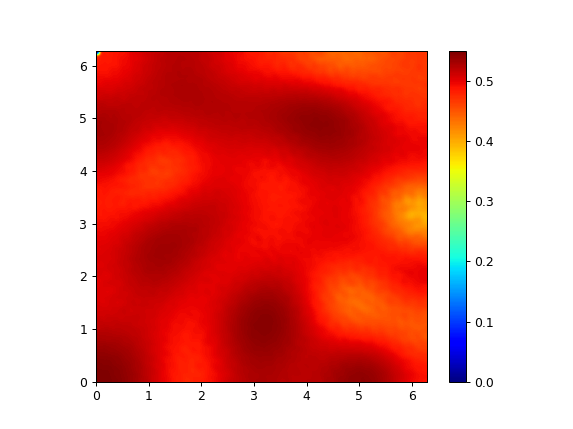

In [11]:
# time stepping
#####################################

(t, T) = (0.0, 1.0)
(n, N) = (0, int(round(T/dt, 0)))

sol = {}
sol['x'] = dofs[ind]
sol['t'] = np.zeros((N,1))
sol['u'] = np.zeros((len(sol['x']), len(sol['t'])))

t0 = perf_counter()
while n < N:
    
    # compute current solution
    solver.solve()
    
    # normalize solution
    # u.vector()[c_dofs] = normalize(u.vector()[c_dofs])
    
    # update previous solution
    u0.vector()[:] = u.vector()
    
    # save output
    sol['t'][n] = t
    sol['u'][:,n] = u.vector()[c_dofs][ind]
    file << (u.split()[0], t)
    
    # print progress
    if n % round(N/10,0) == 0:
        print(f"{n} / {N}")
        
    # increment time
    t += dt
    n += 1
    
tf = perf_counter()
print(f"\nTook {tf-t0:.2f} seconds.")

plt.figure(1)
u_sorted = u.vector()[c_dofs][ind]
u_grid = np.insert(u_sorted, 0, 0).reshape(nx+1, ny+1)
plt.imshow(u_grid, extent=[x0, xf, y0, yf], interpolation='gaussian', cmap='jet')
plt.colorbar()
plt.show()

In [12]:
def snapshot(i):
    plt.clf()
    u_sorted = sol['u'][:,i]
    if square:
        u_grid = u_sorted.reshape(nx+1, ny+1)
    else:
        u_grid = np.insert(u_sorted, 0, 0).reshape(nx+1, ny+1)
    plt.imshow(u_grid, extent=[x0, xf, y0, yf], interpolation='bicubic', cmap='jet')
    plt.rc('xtick',labelsize=12)
    plt.rc('ytick',labelsize=12)
    plt.xlabel('$x$',fontsize='x-large')
    plt.ylabel('$y$',fontsize='x-large')
    plt.title(f'Cahn-Hilliard')
    plt.colorbar()

<IPython.core.display.Javascript object>


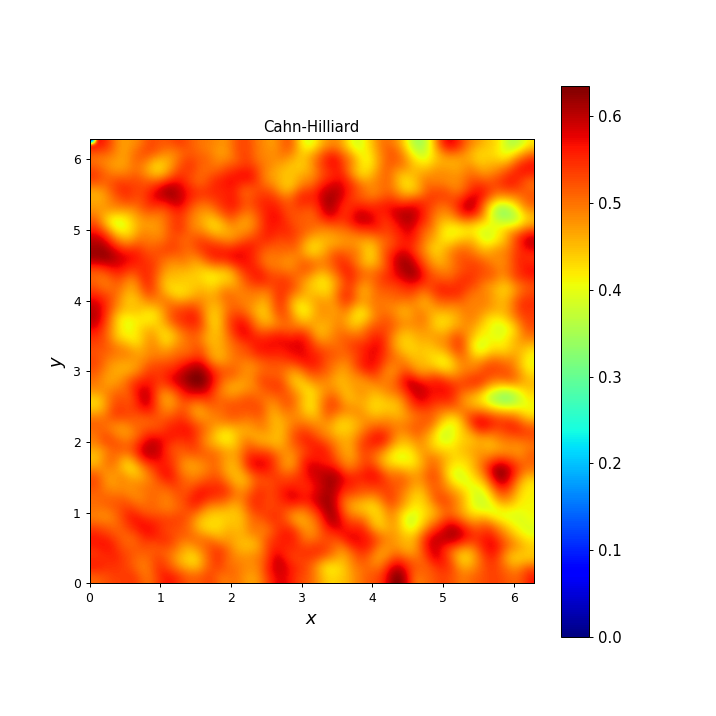

In [13]:
fig = plt.figure(figsize=(8,8), dpi=100)
snapshot(0)

<IPython.core.display.Javascript object>


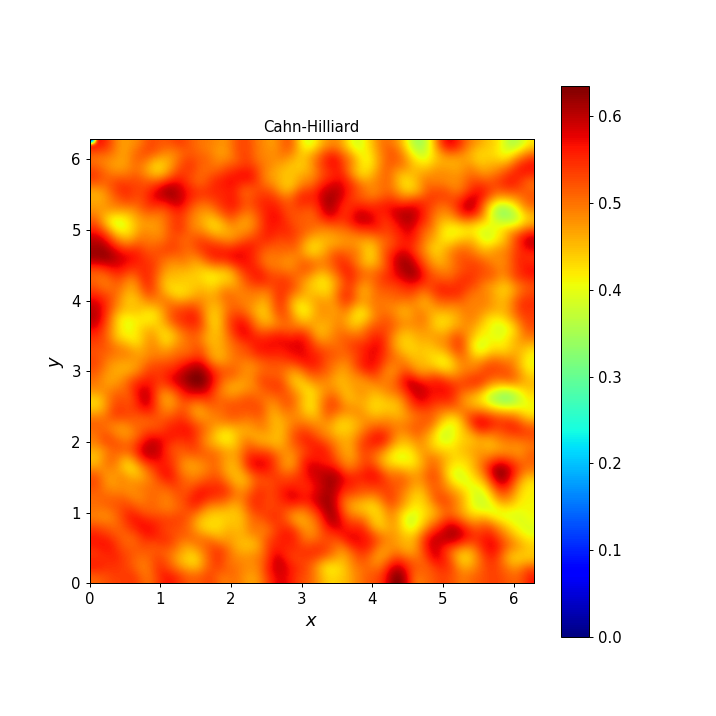

In [14]:
fig = plt.figure(figsize=(8,8), dpi=100)
anim = animation.FuncAnimation(fig,snapshot,frames=N)
if IC == RANDOM_ICs:
    gifname = 'cahn-hilliard-2d_rand.mp4'
elif IC == EXPR_ICs:
    gifname = 'cahn-hilliard-2d_expr.mp4'
anim.save(output + gifname, fps=N/10)